In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime, timedelta


In [28]:
# --- 1. Data Loading and Initial Preparation ---
# IMPORTANT: This section has been updated to load your specific CSV file.

# --- >>> START: YOUR DATA LOADING GOES HERE <<< ---
try:
    # Load your CSV file
    # Assuming your timestamp column is named 'Timestamp' and memory utilization is 'Memory Utilisation %'
    # Adjust 'Timestamp' and 'Memory Utilisation %' if your column names are different.
    df = pd.read_excel('Memory_Util_Today 8.xlsx')

    # Rename columns to match the expected names in the rest of the script
    # This step is crucial for the rest of the code to work correctly.
    # Correcting the column name based on the df.head() output
    df = df.rename(columns={
        'Timestamp': 'timestamp',
        'Memory Utilization': 'memory_utilization_percent' # Corrected column name
    })

    # Convert the timestamp column to datetime objects
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Set the timestamp column as the DataFrame index
    df.set_index('timestamp', inplace=True)

    # Always ensure your data is sorted by time
    df = df.sort_index()

    # Check for the presence of the essential column after renaming
    if 'memory_utilization_percent' not in df.columns:
        raise ValueError("The 'memory_utilization_percent' column was not found after renaming. Please check your Excel column name.")

except FileNotFoundError:
    print("Error: 'Memory_Util_Today 8.xlsx - Sheet1.csv' not found.")
    print("Please ensure the CSV file is in the correct directory or provide the full path.")
    # Fallback to synthetic data for demonstration if file not found
    print("\n--- Generating synthetic data for demonstration as file was not found ---")
    def generate_synthetic_memory_data(num_days=90, start_date_str='2025-04-01 00:00:00'):
        start_time = pd.to_datetime(start_date_str)
        total_intervals = num_days * 24 * 60 * 2
        timestamps = pd.date_range(start=start_time, periods=total_intervals, freq='30S')
        memory_utilization = []
        for i, ts in enumerate(timestamps):
            base = 60 + np.sin(i / (24 * 60 * 2) * 2 * np.pi) * 5
            base += np.sin(i / (7 * 24 * 60 * 2) * 2 * np.pi) * 8
            trend = (i / total_intervals) * 15
            hour = ts.hour
            day_of_week = ts.dayofweek
            spike_factor = 0
            if day_of_week < 5 and (9 <= hour < 17):
                spike_factor = np.random.uniform(0, 10) * np.sin((hour - 9) / 8 * np.pi)
                if ts.minute % 30 == 0 and ts.second == 0:
                     spike_factor += np.random.uniform(0, 5)
            noise = np.random.normal(0, 1.5)
            util = base + trend + spike_factor + noise
            util = max(0, min(100, util))
            memory_utilization.append(util)
        df = pd.DataFrame({'timestamp': timestamps, 'memory_utilization_percent': memory_utilization})
        df.set_index('timestamp', inplace=True)
        return df
    df = generate_synthetic_memory_data(num_days=120)

# --- >>> END: YOUR DATA LOADING <<< ---

print("--- Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()
print(f"\nTotal data points: {len(df)}")
print(f"Data range: {df.index.min()} to {df.index.max()}")

# Ensure consistent 30-second frequency and handle any remaining missing values
# This is crucial for time series models assuming regular intervals.
df_resampled = df.resample('30S').mean()
df_resampled['memory_utilization_percent'] = df_resampled['memory_utilization_percent'].interpolate(method='time')
# Fill any NaNs at the very beginning or end that interpolation couldn't handle
df_resampled['memory_utilization_percent'] = df_resampled['memory_utilization_percent'].fillna(method='ffill').fillna(method='bfill')
df = df_resampled.copy()

print(f"\nData points after resampling and interpolation: {len(df)}")
print(f"New data range after resampling: {df.index.min()} to {df.index.max()}")

--- Data Head ---
                     memory_utilization_percent
timestamp                                      
2025-01-28 14:18:36                          72
2025-01-28 14:19:06                          71
2025-01-28 14:19:36                          72
2025-01-28 14:20:06                          71
2025-01-28 14:20:36                          72

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86374 entries, 2025-01-28 14:18:36 to 2025-02-27 14:18:06
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   memory_utilization_percent  86374 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB

Total data points: 86374
Data range: 2025-01-28 14:18:36 to 2025-02-27 14:18:06

Data points after resampling and interpolation: 86400
New data range after resampling: 2025-01-28 14:18:30 to 2025-02-27 14:18:00


<ipython-input-28-3724933608>:73: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = df.resample('30S').mean()
<ipython-input-28-3724933608>:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled['memory_utilization_percent'] = df_resampled['memory_utilization_percent'].fillna(method='ffill').fillna(method='bfill')



Shape of X (sequences): (86280, 120, 1) (samples, time_steps, features)
Shape of y (targets): (86280,) (samples, 1)

Train set size: 69024 samples
Test set size: 17256 samples (covering 17256 actual timestamps)

--- LSTM Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0063 - val_loss: 3.9112e-04 - learning_rate: 0.0010
Epoch 2/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 8.1263e-04 - val_loss: 4.2182e-04 - learning_rate: 0.0010
Epoch 3/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 6.5636e-04 - val_loss: 3.2315e-04 - learning_rate: 0.0010
Epoch 4/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 5.5846e-04 - val_loss: 3.4003e-04 - learning_rate: 0.0010
Epoch 5/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.7447e-04 - val_loss: 2.8329e-04 - learning_rate: 0.0010
Epoch 6/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 3.8662e-04 - val_loss: 3.5211e-04 - learning_rate: 0.0010
Epoch 7/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 3.2065e-04 - val_loss: 2.6758e-04 - learning_rate: 0.0010
Epoch 8/18
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 2.7701e-04 - val_loss: 2.5477e-04 - learning_rate: 0.0010
Epoch 9/18
486/486

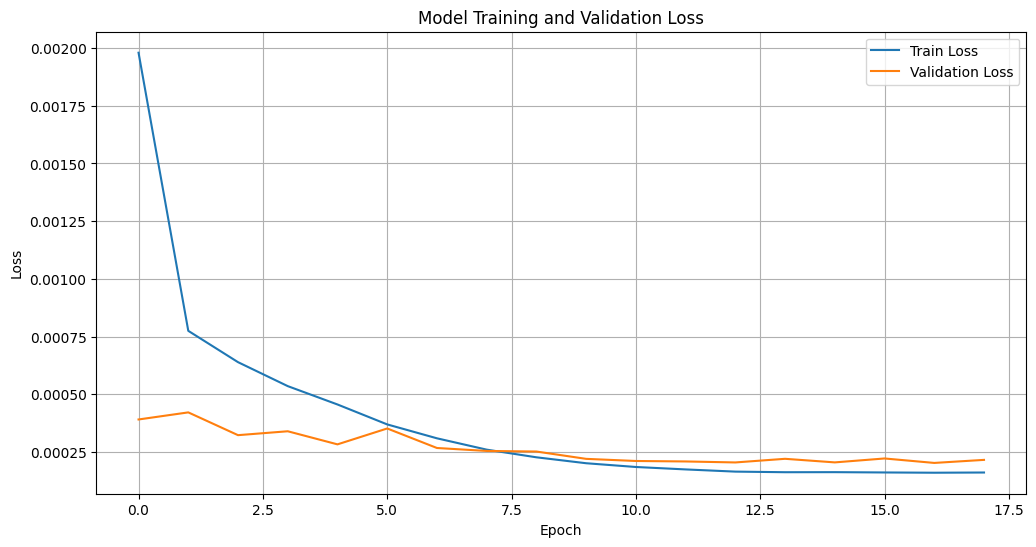


--- Evaluating Model on Test Set ---
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


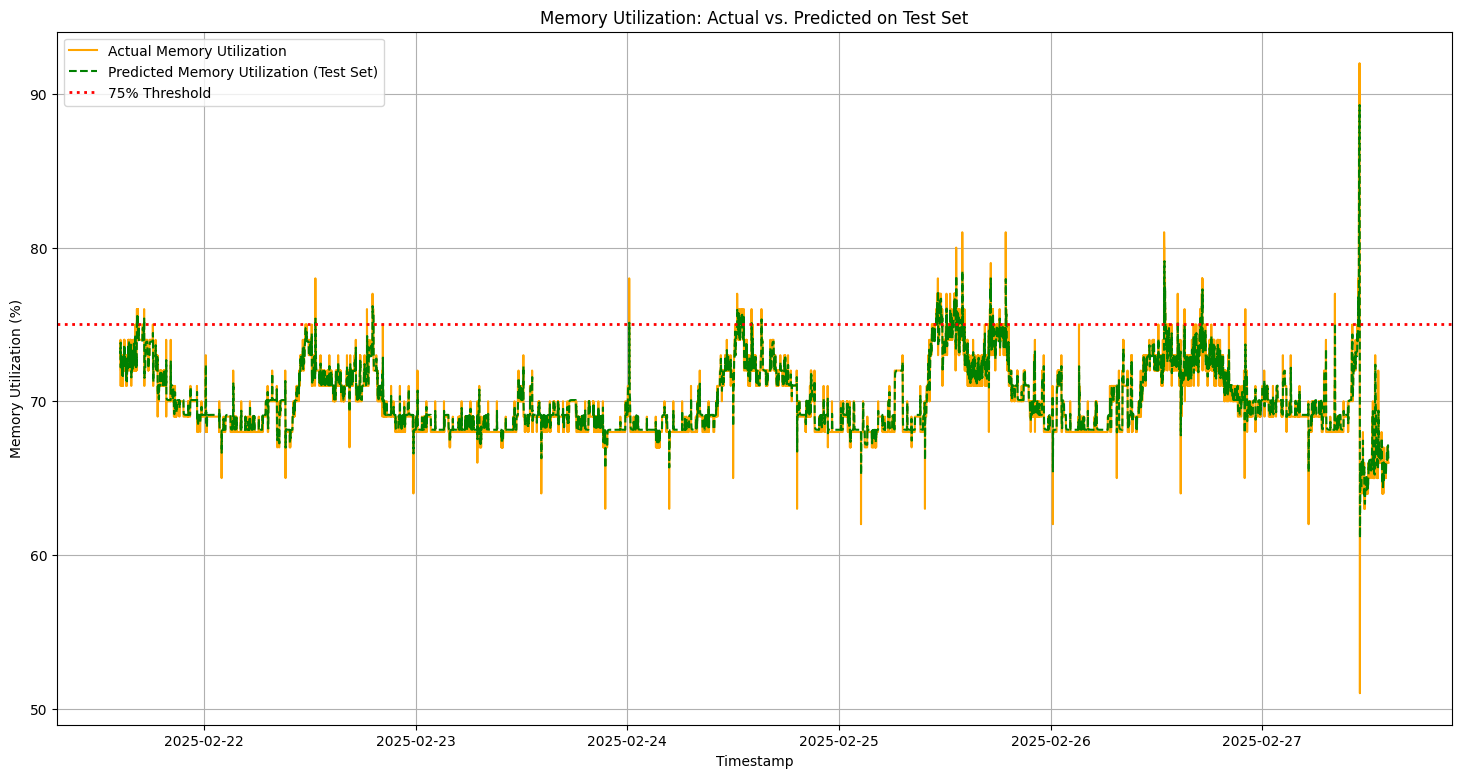

In [40]:

# --- 2. Feature Scaling ---
# Scale memory utilization to a 0-1 range. This is vital for neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['memory_utilization_percent'].values.reshape(-1, 1))

# --- 3. Create Sequences for LSTM ---
# The LSTM will use 'look_back' previous values to predict the next single value.
look_back = 120 # Using 120 past 30-second intervals = 60 minutes of history (1 hour)

def create_sequences(data, look_back):
    """
    Transforms a time series into sequences (X) and corresponding targets (y)
    for supervised learning with LSTMs.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, look_back)

# Reshape input to be [samples, time steps, features] for LSTM
# For this univariate series, features = 1
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"\nShape of X (sequences): {X.shape} (samples, time_steps, features)")
print(f"Shape of y (targets): {y.shape} (samples, 1)")

# --- 4. Train-Test Split (Time-Based) ---
# It's crucial to split data chronologically for time series forecasting.
train_ratio = 0.8 # 80% for training, 20% for testing
train_size = int(len(X) * train_ratio)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Get the corresponding original timestamps for the test set predictions
# The 'y' target for a sequence X[i] is at index i + look_back in the original scaled_data array.
# So, for X_test (which starts at train_size), its first target corresponds to index
# (train_size + look_back) in the original `df.index`.
test_timestamps = df.index[train_size + look_back : train_size + look_back + len(y_test)]

print(f"\nTrain set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples (covering {len(test_timestamps)} actual timestamps)")


# --- 5. Build the LSTM Model ---
model = Sequential()
# First LSTM layer: Takes input_shape (look_back, 1) and outputs sequences for the next LSTM layer.
model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2)) # Dropout for regularization
# Second LSTM layer: Processes the sequences from the first and outputs a single value per sample (not sequences).
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# Output Dense layer: Predicts the single next value.
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks to manage training effectively
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

print("\n--- LSTM Model Summary ---")
model.summary()

# --- 6. Train the LSTM Model ---
print("\n--- Training LSTM Model ---")
history = model.fit(X_train, y_train,
                    epochs=18, # Max epochs, but early stopping will typically stop it sooner
                    batch_size=128, # Adjust based on your dataset size and memory
                    validation_split=0.1, # Use 10% of training data for validation
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Evaluate Model on Test Set ---
print("\n--- Evaluating Model on Test Set ---")
# Get predictions for the test set
test_predictions_scaled = model.predict(X_test)
# Inverse transform predictions and actual values to original scale
test_predictions_original = scaler.inverse_transform(test_predictions_scaled).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame for test set results
test_results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': test_predictions_original
}, index=test_timestamps)

# Plot actual vs. predicted for the test set
plt.figure(figsize=(18, 9))
plt.plot(test_results_df.index, test_results_df['Actual'], label='Actual Memory Utilization', color='orange')
plt.plot(test_results_df.index, test_results_df['Predicted'], label='Predicted Memory Utilization (Test Set)', color='green', linestyle='--')
plt.axhline(y=75, color='red', linestyle=':', label='75% Threshold', linewidth=2)
plt.title('Memory Utilization: Actual vs. Predicted on Test Set')
plt.xlabel('Timestamp')
plt.ylabel('Memory Utilization (%)')
plt.legend()
plt.grid(True)
plt.show()



In [41]:

# --- 7. Evaluate Model on Test Set ---
print("\n--- Evaluating Model on Test Set ---")
# Get predictions for the test set
test_predictions_scaled = model.predict(X_test)
# Inverse transform predictions and actual values to original scale
test_predictions_original = scaler.inverse_transform(test_predictions_scaled).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame for test set results
test_results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': test_predictions_original
}, index=test_timestamps)



--- Evaluating Model on Test Set ---
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


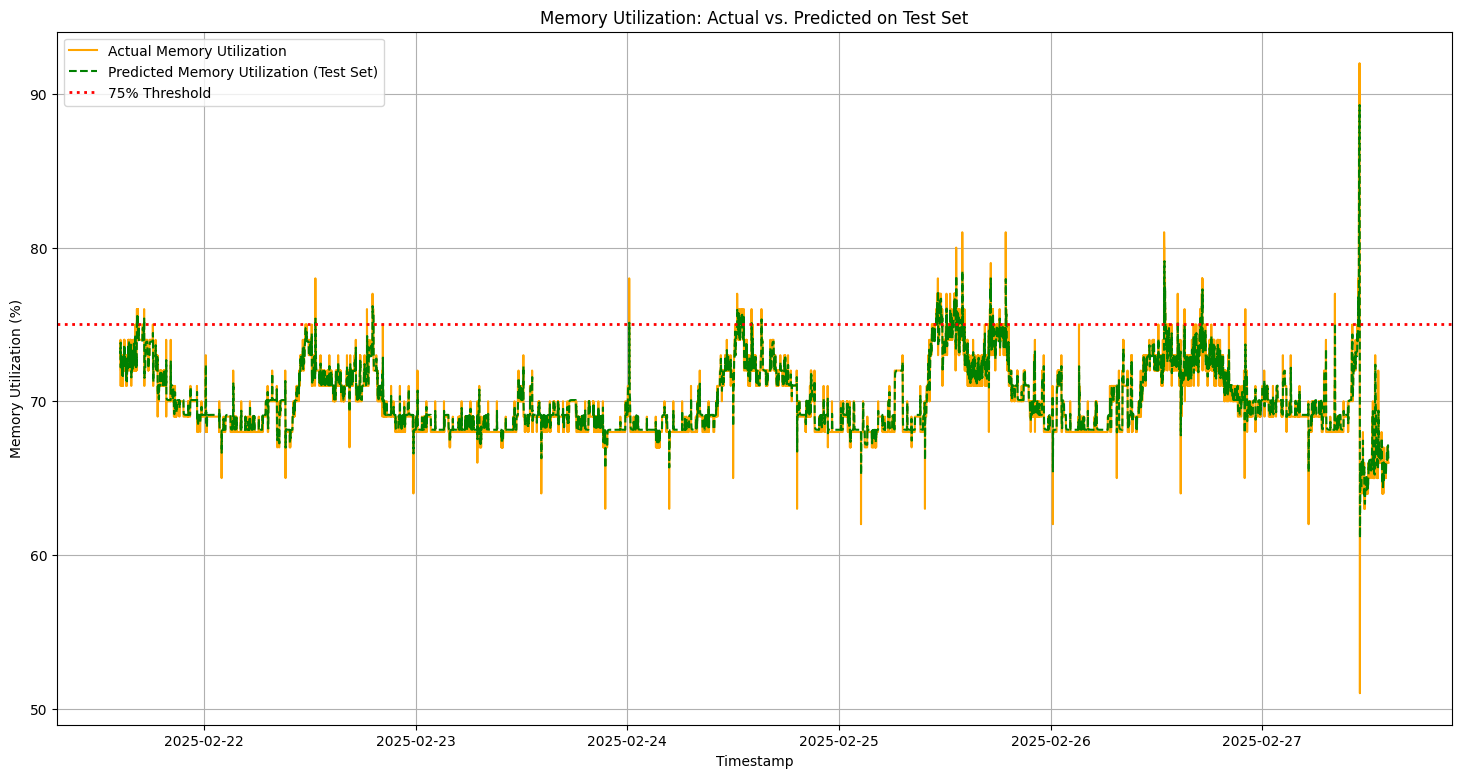

In [42]:

# Plot actual vs. predicted for the test set
plt.figure(figsize=(18, 9))
plt.plot(test_results_df.index, test_results_df['Actual'], label='Actual Memory Utilization', color='orange')
plt.plot(test_results_df.index, test_results_df['Predicted'], label='Predicted Memory Utilization (Test Set)', color='green', linestyle='--')
plt.axhline(y=75, color='red', linestyle=':', label='75% Threshold', linewidth=2)
plt.title('Memory Utilization: Actual vs. Predicted on Test Set')
plt.xlabel('Timestamp')
plt.ylabel('Memory Utilization (%)')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
 #-- 8. Forecast into the Future (Beyond current historical data) ---
# This involves iteratively predicting and feeding the prediction back as input.

num_future_intervals = 24 * 60 * 2 # Forecast for the next 24 hours (2880 intervals)
future_forecast_scaled = []

# Ensure scaled_data has enough points for look_back
if len(scaled_data) < look_back:
    print(f"Error: Not enough historical data ({len(scaled_data)} points) for look_back ({look_back} points). Cannot forecast.")
else:
    # Get the last 'look_back' points from the original scaled data to start forecasting
    current_input_sequence = scaled_data[-look_back:].reshape(1, look_back, 1)

    print(f"\n--- Forecasting {num_future_intervals} intervals ({num_future_intervals / (60*2)} hours) into the future ---")
    for i in range(num_future_intervals):
        # Predict the next single value
        next_prediction_scaled = model.predict(current_input_sequence, verbose=0)[0, 0]
        future_forecast_scaled.append(next_prediction_scaled)

        # Update the input sequence: drop the oldest value, add the new prediction
        # The key change is ensuring `next_prediction_scaled` is reshaped to (1, 1, 1) before appending.
        current_input_sequence = np.append(current_input_sequence[:, 1:, :],
                                           next_prediction_scaled.reshape(1, 1, 1),
                                           axis=1)

    # Inverse transform the future forecast to original scale
    future_forecast_original = scaler.inverse_transform(np.array(future_forecast_scaled).reshape(-1, 1)).flatten()

    # Create timestamps for the future forecast
    last_historical_timestamp = df.index[-1]
    future_timestamps = pd.date_range(start=last_historical_timestamp + pd.Timedelta(seconds=30),
                                      periods=num_future_intervals,
                                      freq='30S')

    future_forecast_df = pd.DataFrame({
        'predicted_memory_utilization': future_forecast_original
    }, index=future_timestamps)



--- Forecasting 2880 intervals (24.0 hours) into the future ---


<ipython-input-45-2526113868>:31: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_timestamps = pd.date_range(start=last_historical_timestamp + pd.Timedelta(seconds=30),



--- Analyzing Future Forecast for 75% Threshold ---
Predicted next timestamp to hit 75.0%: Not predicted within the forecast horizon.
No periods above 75.0% predicted in the future horizon.


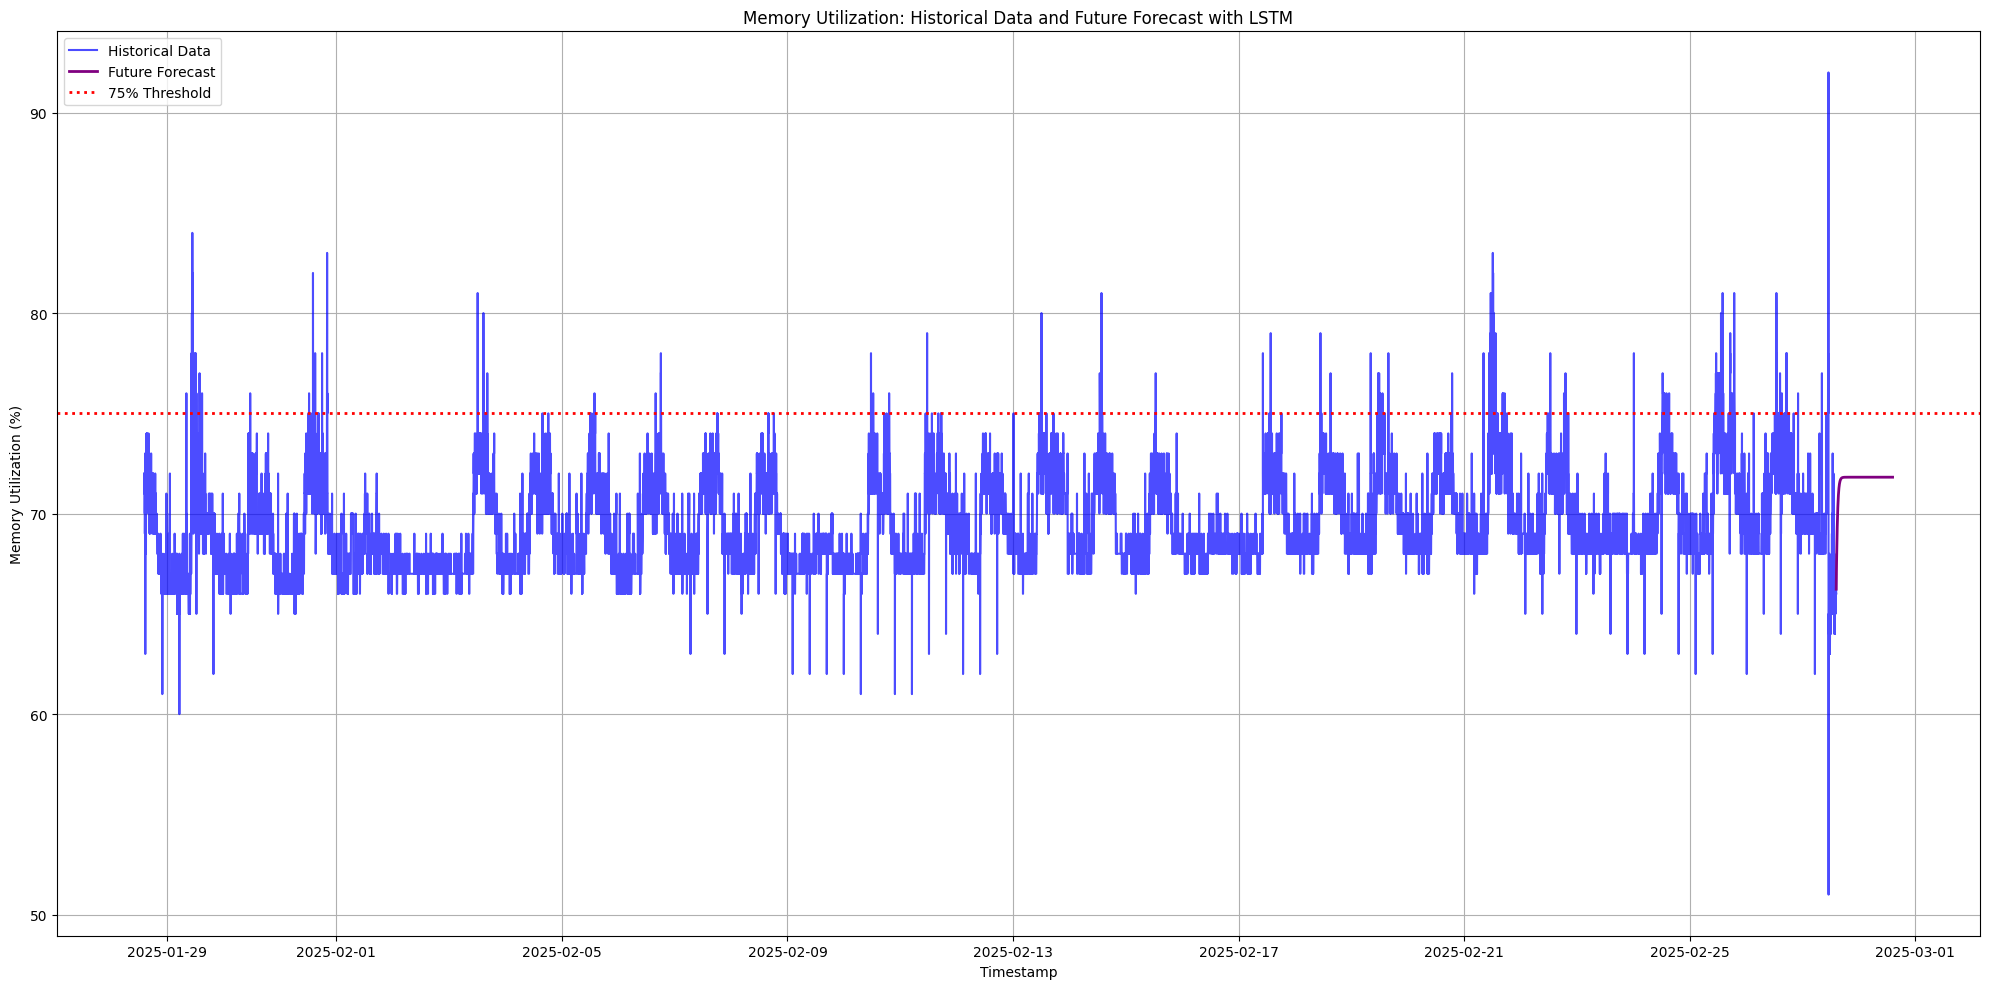


--- Combined Plot of Historical Data and Future Forecast ---


In [68]:
 #--- 9. Analyze Future Forecast for 75% Threshold ---
# This section will only run if future_forecast_df was successfully created in step 8
if 'future_forecast_df' in locals():
    print(f"\n--- Analyzing Future Forecast for {75}% Threshold ---")
    threshold = 75.0
    first_hit_timestamp = None
    above_threshold_periods = []
    current_above_start = None

    for timestamp, predicted_value in future_forecast_df['predicted_memory_utilization'].items():
        if predicted_value >= threshold:
            if first_hit_timestamp is None:
                first_hit_timestamp = timestamp
            if current_above_start is None:
                current_above_start = timestamp
        else: # If prediction drops below threshold
            if current_above_start is not None:
                # End of a period above threshold: The timestamp BEFORE it dropped below
                period_end = timestamp - pd.Timedelta(seconds=30)
                above_threshold_periods.append({
                    'start': current_above_start,
                    'end': period_end
                })
                current_above_start = None # Reset for the next potential period

    # Handle the case where the forecast ends while still above the threshold
    if current_above_start is not None:
        above_threshold_periods.append({
            'start': current_above_start,
            'end': future_forecast_df.index[-1] # Extends to the end of the forecast horizon
        })

    print(f"Predicted next timestamp to hit {threshold}%: {first_hit_timestamp if first_hit_timestamp else 'Not predicted within the forecast horizon.'}")

    if above_threshold_periods:
        print(f"\nPredicted periods above {threshold}%:")
        for i, period in enumerate(above_threshold_periods):
            # To ensure the 'end' timestamp is actually the last point >= threshold, not the first point < threshold
            # We fetch the actual value at period['end'] and the preceding one if available.
            # This logic helps refine boundary reporting.
            actual_end_point_value = future_forecast_df.loc[period['end'], 'predicted_memory_utilization']

            # Check if the period is valid and not just a single, brief dip below the threshold
            if period['start'] == period['end']:
                if actual_end_point_value >= threshold:
                    print(f"  {i+1}. At {period['start']} (hit at this specific timestamp)")
            else:
                # Validate if the entire reported segment was truly above/at threshold
                segment_check = future_forecast_df.loc[period['start']:period['end'], 'predicted_memory_utilization']
                if not segment_check.empty and segment_check.min() >= (threshold - 0.001): # Small tolerance for float
                    print(f"  {i+1}. From {period['start']} to {period['end']}")
                # else: print(f"  Skipped invalid segment from {period['start']} to {period['end']}") # For debugging
    else:
        print(f"No periods above {threshold}% predicted in the future horizon.")


    # --- 10. Combined Plot of Historical Data and Future Forecast ---
    plt.figure(figsize=(20, 10))
    plt.plot(df.index, df['memory_utilization_percent'], label='Historical Data', color='blue', alpha=0.7)
    plt.plot(future_forecast_df.index, future_forecast_df['predicted_memory_utilization'], label='Future Forecast', color='purple', linestyle='-', linewidth=2)
    plt.axhline(y=75, color='red', linestyle=':', label='75% Threshold', linewidth=2)
    plt.title('Memory Utilization: Historical Data and Future Forecast with LSTM')
    plt.xlabel('Timestamp')
    plt.ylabel('Memory Utilization (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("\n--- Combined Plot of Historical Data and Future Forecast ---")
else:
    print("\nFuture forecasting and threshold analysis skipped due to insufficient historical data.")

